In [ ]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math, cmath
from scipy.stats import norm
from scipy import integrate

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/PDE/Data/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Heston Model


$$ \frac{dS(t)}{S(t)} = rdt+\sqrt{V(t)}dW_1$$
$$ dV(t) = \kappa(\theta -V(t)) dt+\sigma\sqrt{V(t)}dW_2$$
$$ dW_1 \dot dW_2 = \rho dt $$


## transformation s.t. the integration has is bounded

$$ x= \ln(\frac{1}{t}) \Rightarrow dx = 1/(1/t) * (-1/t^2) dt = -\frac{1}{t} dt $$

$$ \int_0^\infty f(x) \;dx \Rightarrow \int_0^1 \frac{f(\ln(\frac{1}{t}))}{t} \;dt$$


## Heston class to calculate closed-form call price

In [ ]:
# Please refer to HestonModel for comments on this part
class Heston2:
    i=complex(0,1)
    def __init__(self,St,Vt,K,lamda,tau,v_bar,eta,rho,r=0,q=0, maxiter=100):
        self.St = St            # current underlying price (S0)
        self.Vt = Vt            # current underlying variance (V0)
        self.K = K              # strike price
        self.lamda = lamda      # variance mean reversion rate    
        self.tau = tau          # T-t
        self.v_bar = v_bar      # long-term variance
        self.eta = eta          # vol of vol
        self.rho = rho          # correlation between 2 brownian motion
        self.r = r              # risk-free interest rate
        self.q = q              # dividend yield
        self.maxiter = maxiter
        self._preSet()

    def _preSet(self):
      self.x = np.log(self.St*np.exp(self.r*self.tau)/self.K)
      self.gamma = 0.5*self.eta**2
    
    def _alpha(self,u):
      self.alpha_0 = -0.5*u**2 -0.5*u*self.i 
      self.alpha_1 = -0.5*u**2 +0.5*u*self.i 

    def _beta(self,u):
      self.beta_0 = self.lamda - self.rho*self.eta*self.i*u
      self.beta_1 = self.lamda - self.rho*self.eta - self.rho*self.eta*self.i*u

    def _d(self,u):
      self.d_0 = np.sqrt(self.beta_0**2 - 4*self.alpha_0*self.gamma)
      self.d_1 = np.sqrt(self.beta_1**2 - 4*self.alpha_1*self.gamma)

    def _R(self,u):
      self.R_pos_0 = (self.beta_0 + self.d_0)/(2*self.gamma)
      self.R_pos_1 = (self.beta_1 + self.d_1)/(2*self.gamma)
      self.R_neg_0 = (self.beta_0 - self.d_0)/(2*self.gamma)
      self.R_neg_1 = (self.beta_1 - self.d_1)/(2*self.gamma)

    def _g(self,u):
      self.g_0 = self.R_neg_0/self.R_pos_0
      self.g_1 = self.R_neg_1/self.R_pos_1

    def _D(self,u):
      self.D_0 = self.R_neg_0 * (1-np.exp(-self.d_0*self.tau))/(1-self.g_0*np.exp(-self.d_0*self.tau))
      self.D_1 = self.R_neg_1 * (1-np.exp(-self.d_1*self.tau))/(1-self.g_1*np.exp(-self.d_1*self.tau))

    def _C(self,u):
      self.C_0 = self.lamda * ( self.R_neg_0*self.tau - 1/self.gamma * np.log( (1-self.g_0*np.exp(-self.d_0*self.tau))/(1-self.g_0) ))
      self.C_1 = self.lamda * ( self.R_neg_1*self.tau - 1/self.gamma * np.log( (1-self.g_1*np.exp(-self.d_1*self.tau))/(1-self.g_1) ))
     
    def P_telda_0(self,u):
      self._alpha(u)
      self._beta(u)
      self._d(u)
      self._R(u)
      self._g(u)
      self._D(u)
      self._C(u)
      
      exp_term = self.C_0*self.v_bar + self.D_0*self.Vt + self.i*u*self.x
      P_telda_complex = np.exp(exp_term) /(self.i*u)

      return P_telda_complex.real

    def P_telda_1(self,u):
      self._alpha(u)
      self._beta(u)
      self._d(u)
      self._R(u)
      self._g(u)
      self._D(u)
      self._C(u)
      
      exp_term = self.C_1*self.v_bar + self.D_1*self.Vt + self.i*u*self.x
      P_telda_complex = np.exp(exp_term) /(self.i*u)

      return P_telda_complex.real
    
    def transformed_P_telda_0(self,u):
      return self.P_telda_0(np.log(1/u))/u
    def transformed_P_telda_1(self,u):
      return self.P_telda_1(np.log(1/u))/u

    def P_0_Int(self, useGaussianQuad, UB=100):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.P_telda_0,0,UB, maxiter=self.maxiter)
      else:
        val, err =  integrate.quad(self.P_telda_0, 0, np.inf, limit = self.maxiter)
      # print('Value of Gaussian Quadrature 0: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 0: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_0_transInt(self,useGaussianQuad):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.transformed_P_telda_0,0.0,1.0, maxiter=self.maxiter)
      else:
        val, err, =  integrate.quad(self.transformed_P_telda_0, 0.0, 1.0 , limit = self.maxiter)
      # print('Value of Gaussian Quadrature 0: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 0: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_1_Int(self,useGaussianQuad,UB=100):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.P_telda_1,0,UB, maxiter=self.maxiter)
      else:
        val, err =  integrate.quad(self.P_telda_1, 0.0, np.inf, limit = self.maxiter)
      # print('Value of Gaussian Quadrature 1: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 1: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_1_transInt(self,useGaussianQuad):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.transformed_P_telda_1,0.0,1.0, maxiter=self.maxiter)
      else:
        val, err =  integrate.quad(self.transformed_P_telda_1, 0.0, 1.0, limit = self.maxiter)

      # print('Value of Gaussian Quadrature 1: ', 0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 1: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def CallPrice(self,useTransInt= False, useGaussianQuad = False):
      if useTransInt:
        return self.K*np.exp(-self.r*self.tau)*( np.exp(self.x) * self.P_1_transInt(useGaussianQuad) - self.P_0_transInt(useGaussianQuad) )
      else:
        return self.K*np.exp(-self.r*self.tau)*( np.exp(self.x) * self.P_1_Int(useGaussianQuad) - self.P_0_Int(useGaussianQuad) )

    def setDetails(self, Vt, St, K, tau, r, q=0):
      self.St = St
      self.Vt = Vt
      self.K = K
      self.tau = tau
      self.r = r
      self.q = q
      self._preSet()

    def _print(self):
      print(self.St, self.Vt, self.K, self.tau, self.r, self.q)

    def printParams(self):
      print("St: ", self.St)
      print("K: ", self.K)
      print("tau: ", self.tau)
      print("r: ", self.r)
      print("q: ", self.q)
      print("lambda: ", self.lamda)
      print("eta: ", self.eta)
      print("v_bar: ", self.v_bar)
      print("Vt: ", self.Vt)
      print("rho: ", self.rho)

    def Delta(self, epsilon = 0.002):
      St = self.St
      call_ori = self.CallPrice()
      self.St += epsilon
      self._preSet()
      call_pos = self.CallPrice()
      self.St = St
      self._preSet()
      return (call_pos - call_ori)/epsilon
    
    def Gamma(self, epsilon = 0.002):
      St = self.St
      call_ori = self.CallPrice()
      self.St += epsilon
      self._preSet()
      call_pos = self.CallPrice()
      self.St -= 2*epsilon
      self._preSet()
      call_neg = self.CallPrice()
      self.St = St
      self._preSet()
      return (call_pos - 2*call_ori + call_neg)/(epsilon**2)

    def Vega(self, epsilon = 0.002):
      Vt = self.Vt
      call_ori = self.CallPrice()
      self.Vt += epsilon
      self._preSet()
      call_pos = self.CallPrice()
      self.Vt = Vt
      self._preSet()
      return (call_pos - call_ori)/epsilon*0.01 # one-percent change


    def Theta(self, epsilon = 0.002):
      tau = self.tau
      call_ori = self.CallPrice()
      self.tau += epsilon
      self._preSet()
      call_pos = self.CallPrice()
      self.tau = tau
      self._preSet()
      return (call_ori - call_pos)/epsilon/255  # per-day theta
    
    def Rho(self, epsilon = 0.00002):
      r = self.r
      call_ori = self.CallPrice()
      self.r += epsilon
      self._preSet()
      call_pos = self.CallPrice()
      self.r = r
      self._preSet()
      return (call_pos - call_ori)/epsilon*0.01 # one-percent change


In [ ]:
# parameter setup
St = 100            # current underlying price (S0)
Vt = 0.5**2         # current underlying variance (V0)
K = 100             # strike price
lamda = 5           # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2     # long-term variance
eta = 0.3           # vol of vol
rho = 0.3           # correlation between 2 brownian motion
r = 0.014           # risk-free interest rate
q = 0               # dividend yield
maxiter = 10000

# Base case
heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q, maxiter)
print('Call Price: ',heston_obj.CallPrice(),'\n',
      'Delta: ',heston_obj.Delta(),'\n',
      'Gamma: ',heston_obj.Gamma(),'\n',
      'Vega: ', heston_obj.Vega(),'\n',
      'Theta:', heston_obj.Theta(),'\n',
      'Rho: ',  heston_obj.Rho())

Call Price:  8.952267992865524 
 Delta:  0.542927301800944 
 Gamma:  0.017997382695256192 
 Vega:  0.12816327259940863 
 Theta: -0.058190647159377294 
 Rho:  0.11334749762870187


## Quadrature Plot

In [ ]:
# show the quadrature fails when tau approachs a certain number
gaussianQuad = []
qquad = []
tlist = np.linspace(0.02,1)
for t in tlist:
  heston_obj = Heston2(St,Vt,K,lamda,t,v_bar,eta,rho,r,q, maxiter)
  gaussianQuad.append(heston_obj.P_1_Int(True))
  qquad.append(heston_obj.P_1_Int(False))

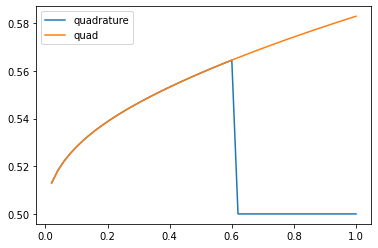

In [ ]:
# Plot figure
plt.plot(tlist, gaussianQuad, label = 'quadrature')
plt.plot(tlist, qquad, label = 'quad')
plt.legend()
plt.show()

# Greeks

In [ ]:
# Predefined plot parameters
tlist = [0.25, 0.5, 1]
Greeks = ['Delta', 'Gamma', 'Vega', 'Theta','Rho']
Slist = np.linspace(K-50,K+50,100)

In [ ]:
# Store Greeks' value into DataFrame
for i in Greeks:
  exec(f'df_{i} = pd.DataFrame(index = tlist, columns = Slist) ')
for t in tlist:
  for Si in Slist:
    heston_obj = Heston2(Si,Vt,K,lamda,t,v_bar,eta,rho,r,q, maxiter)
    df_Delta.at[t,Si] = heston_obj.Delta()
    df_Gamma.at[t,Si] = heston_obj.Gamma()
    df_Vega.at[t,Si] = heston_obj.Vega()
    df_Theta.at[t,Si] = heston_obj.Theta()
    df_Rho.at[t,Si] = heston_obj.Rho()


## Delta

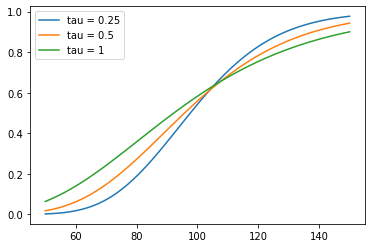

In [ ]:
# Plot Delta
for t in tlist:
  plt.plot(Slist, df_Delta.loc[t], label = 'tau = ' + str(t))
plt.legend()
plt.show()

## Gamma

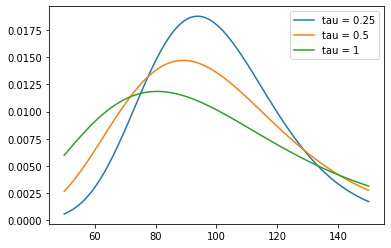

In [ ]:
# Plot Gamma
for t in tlist:
  plt.plot(Slist, df_Gamma.loc[t], label = 'tau = ' + str(t))
plt.legend()
plt.show()

## Vega

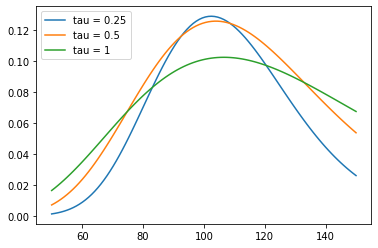

In [ ]:
# Plot Vega
for t in tlist:
  plt.plot(Slist, df_Vega.loc[t], label = 'tau = ' + str(t))
plt.legend()
plt.show()

## Theta

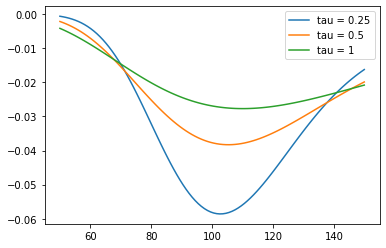

In [ ]:
# Plot Theta
for t in tlist:
  plt.plot(Slist, df_Theta.loc[t], label = 'tau = ' + str(t))
plt.legend()
plt.show()

## Rho

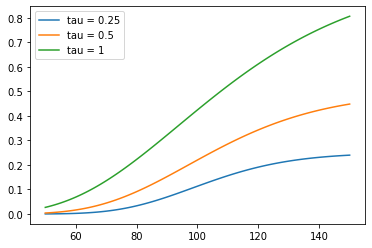

In [ ]:
# Plot Rho
for t in tlist:
  plt.plot(Slist, df_Rho.loc[t], label = 'tau = ' + str(t))
plt.legend()
plt.show()

## Case Check: BS Formula

In [ ]:
# class BlackScholes, please refer to Monte Carlo Simulation for further reference
class BlackScholes:
    @staticmethod
    def EurCall_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return S*np.exp(-q*tau)*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)
    @staticmethod
    def EurPut_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return  K*np.exp(-r*tau)*norm.cdf(-d2) - S*np.exp(-q*tau)*norm.cdf(-d1) 
        
    @staticmethod        
    def d1_BS(S,K,tau,sigma,r,q=0):
        d1 = (np.log(S/K) +( r- q + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        return d1
    @staticmethod        
    def d2_BS(S,K,tau,sigma,r,q=0):
        d2 = BlackScholes.d1_BS(S,K,tau,sigma,r,q)-sigma*np.sqrt(tau)
        return d2
    
    @staticmethod       
    def delta_call_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0))   
    @staticmethod       
    def delta_put_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*(norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)) -1)
    
    @staticmethod       
    def vega_BS(S, K, tau, r, sigma, q=0):
        d1 =  BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        return S * norm.pdf(d1) * np.sqrt(tau) * np.exp(-q*tau) 

    @staticmethod
    def impliedVol(marketPrice, S,K,tau,r, q=0, IsCall=True):
        MAX_ITERATIONS = 200
        PRECISION = 1.0e-5
        sigma = 0.5
        for i in range(0, MAX_ITERATIONS):
            if IsCall:
                modelPrice = BlackScholes.EurCall_BS(S,K,tau,sigma,r, q) 
            else:
                modelPrice = BlackScholes.EurPut_BS(S,K,tau,sigma,r, q) 

            vega = BlackScholes.vega_BS(S, K, tau, r, sigma,q)
            diff = marketPrice - modelPrice  # our root
            if (abs(diff) < PRECISION):
                return sigma
            sigma = sigma + diff/vega # f(x) / f'(x)
        return sigma # value wasn't found, return best guess so far

In [ ]:
# Test case parameters
St = 100            # current underlying price (S0)
Vt = 0.5**2         # current underlying variance (V0)
K = 100             # strike price
lamda = 5           # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.5**2      # long-term variance
eta = 0.3           # vol of vol
rho = 0.3           # correlation between 2 brownian motion
r = 0.014           # risk-free interest rate
q = 0               # dividend yield
maxiter = 10000

BSCall = BlackScholes.EurCall_BS(St,K,tau,np.sqrt(Vt),r,q)
heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q, maxiter)
HestonCall = heston_obj.CallPrice()

In [ ]:
# Calculate converge value
etaList = np.linspace(0.5,0.0002)
HestonCall = []
BSEurCall = BlackScholes.EurCall_BS(St,K,tau,np.sqrt(Vt),r,q)
BSCall = []
for e in etaList:
  heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,e,rho,r,q, maxiter)
  HestonCall.append(heston_obj.CallPrice())
  BSCall.append(BSEurCall)

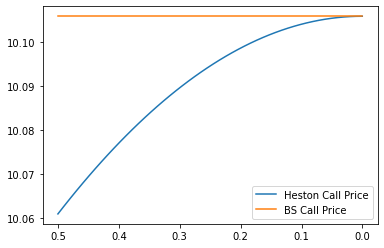

In [ ]:
# Show Converge results
plt.plot(etaList, HestonCall, label = 'Heston Call Price')
plt.plot(etaList, BSCall, label = 'BS Call Price')
plt.gca().invert_xaxis()
plt.legend()
plt.show()